In [1]:
#######################
# Goal of this code is to recalculate correlation between q and precip (Q1)
# 2024.7.25 originally written, updated 2024.9.21
####################################

In [2]:
import os
import sys
sys.path.append('/glade/work/muting/function/')
#import KW_diagnostics as KW
#import mjo_mean_state_diagnostics as MJO
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dir_out            = '/glade/work/muting/KW/'
CASENAME_LIST2     = list(['SST_AQP3_Qobs_27_-4K',\
                          'SST_AQP3_Qobs_27',\
                          'SST_AQP3_Qobs_27_4K'])
CASENAME_SHORT_LIST = list(['-4K','CTL','4K'])
NUDGE_LIST     = list(['3h_20y_CLUBB_new','3h_20y_CLUBB_new_uv_tendency','3h_20y_CLUBB_new'])
#figdir_all     = dir_out+'figure/Post_general/Paper4_prep/pr_q_correlation/' #original directory
figdir_all     = dir_out+'figure/Post_general/Paper4_20240822/' #updated directory

V1_plev_name = list(['q_ano_small','T_ano_small'])
V2_name = list(['pr_kwproj_ano','PC1_Q'])
V1_short = list(['qv','T'])
V2_short = list(['pr','PCQ1'])

In [24]:
# Calculate corrcoef between q and PCQ1
average_vertical_level = 1 # 0 or 1, (1 has better results) depends on whether calculating corrcoef with averaged vertical layer (1000-950, 950-900....) or not

for icase in range(0, 3):
    
    CASENAME       = CASENAME_LIST2[icase]+'_'+NUDGE_LIST[icase]
    output_dir     = dir_out+'output_data/'+CASENAME+'/'
    figdir         = dir_out+'figure/Post_general/Paper4_prep/pr_q_correlation/'+CASENAME_SHORT_LIST[icase]+'/'
    os.makedirs(figdir,exist_ok=True) 
    CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_CLUBB_new'
    print(CASENAME)

    # 1. Load precip anomaly (KW-meridional projection)
    data          = np.load(output_dir+'precip_kw.npz')
    pr_kwproj_ano = data['pr_kwproj_ano_short']
    lon           = data['lon']
    time_pr       = data['time_pr']
    phase_correct = data['phase_correct']
    nt_new        = np.size(time_pr)
    nlon          = np.size(lon)

    #if icase == 0:
    # Load qv anomaly (KW-meridional projection)
    data    = np.load(output_dir+'QTUVZq.npz')
    time_q  = data['time'][time_pr[0]:time_pr[-1]+1]
    q_ano   = data['qa'][time_pr[0]:time_pr[-1]+1,:,:]
    plev    = data['plev']
    #print(plev)
    ilevmin = np.argwhere(plev==50).squeeze()
    ilevmax = np.argwhere(plev==950).squeeze()
    q_ano_small = q_ano[:,ilevmin:ilevmax+1,:]
    plev_small  = plev[ilevmin:ilevmax+1]
    nlev = np.size(plev_small)
    # Load Q1_ano
    Q_ano = data['Qa'][time_pr[0]:time_pr[-1]+1,:,:]
    # Load T anomaly 
    T_ano_small = data['Ta'][time_pr[0]:time_pr[-1]+1,ilevmin:ilevmax+1,:]

    # Load EOF
    data = np.load(output_dir+'EOF.npz')
    EOF1 = data['R_EOF1_smooth']
    EOF2 = data['R_EOF2_smooth']
    plev = data['plev']
    
    tmp = np.transpose(Q_ano, (0,2,1))
    PC1_Q = np.inner(tmp, EOF1)
    PC2_Q = np.inner(tmp, EOF2)

    # 2. Calculate correlation coefficient between q and pr, T and pr

    for n1 in range(0, np.size(V1_plev_name)):
        V1 = globals()[V1_plev_name[n1]]
        
        for n2 in range(0, np.size(V2_name)):
            V2 = globals()[V2_name[n2]]
            
            if np.shape(V2)!=np.shape(V1[:,0,:]):
                print('Shape mismatches between q and precip!')
            else:
                if average_vertical_level == 1:
                    # Seperate vertical level of moisture
                    plev_st = np.arange(50,1000,50)
                    plev_end = plev_st+50
                    nlev_new = np.size(plev_st) # average over each layer (200-250, 250-300,.....900-950)
                    #qv_kw_new = np.empty([nph, nlev_new, 3])
                    V1_new = np.empty([nt_new, nlev_new, nlon])
                    
                    for i in range(0,nlev_new):
                        #qv_kw_new[:,i,:]    = np.mean(qv_kw_all[:, i*3-i:(i+1)*3-i, :],1)
                        V1_new[:,i,:] = np.mean(V1[:, i*3-i:(i+1)*3-i, :,],1)
                    
                    # Calculate correlation coefficient between qv and precip
                    r = np.empty([nlev_new])
                    for i in range(0,nlev_new):
                        #tmp = np.corrcoef(qv_kw_new[:,i,icase], pr_kw_all[:,icase])
                        #r_kw[i,icase] = tmp[0,1]
                        tmp = np.corrcoef( np.ndarray.flatten(V1_new[:,i,:]), np.ndarray.flatten(V2[:,:]) )
                        r[i] = tmp[0,1]
        
                    plev_new = (plev_st+plev_end)/2
                    np.savez(output_dir+'corrcoef_'+V1_short[n1]+'_'+V2_short[n2]+'_level.npz', r=r, plev=plev_new)
                
                elif average_vertical_level == 0:
                    r = np.empty([nlev])
                    # Calculate correlation coefficient between qv and precip
                    for i in range(0,nlev):
                        #tmp = np.corrcoef(qv_kw_new[:,i,icase], pr_kw_all[:,icase])
                        #r_kw[i,icase] = tmp[0,1]
                        tmp = np.corrcoef( np.ndarray.flatten(V1[:,i,:]), np.ndarray.flatten(V2[:,:]) )
                        r[i] = tmp[0,1]
                    np.savez(output_dir+'corrcoef_'+V1_short[n1]+'_'+V2_short[n2]+'_level_not-averaged.npz', r=r, plev=plev_small)

SST_AQP3_Qobs_27_-4K_3h_20y_CLUBB_new
SST_AQP3_Qobs_27_3h_20y_CLUBB_new_uv_tendency
SST_AQP3_Qobs_27_4K_3h_20y_CLUBB_new


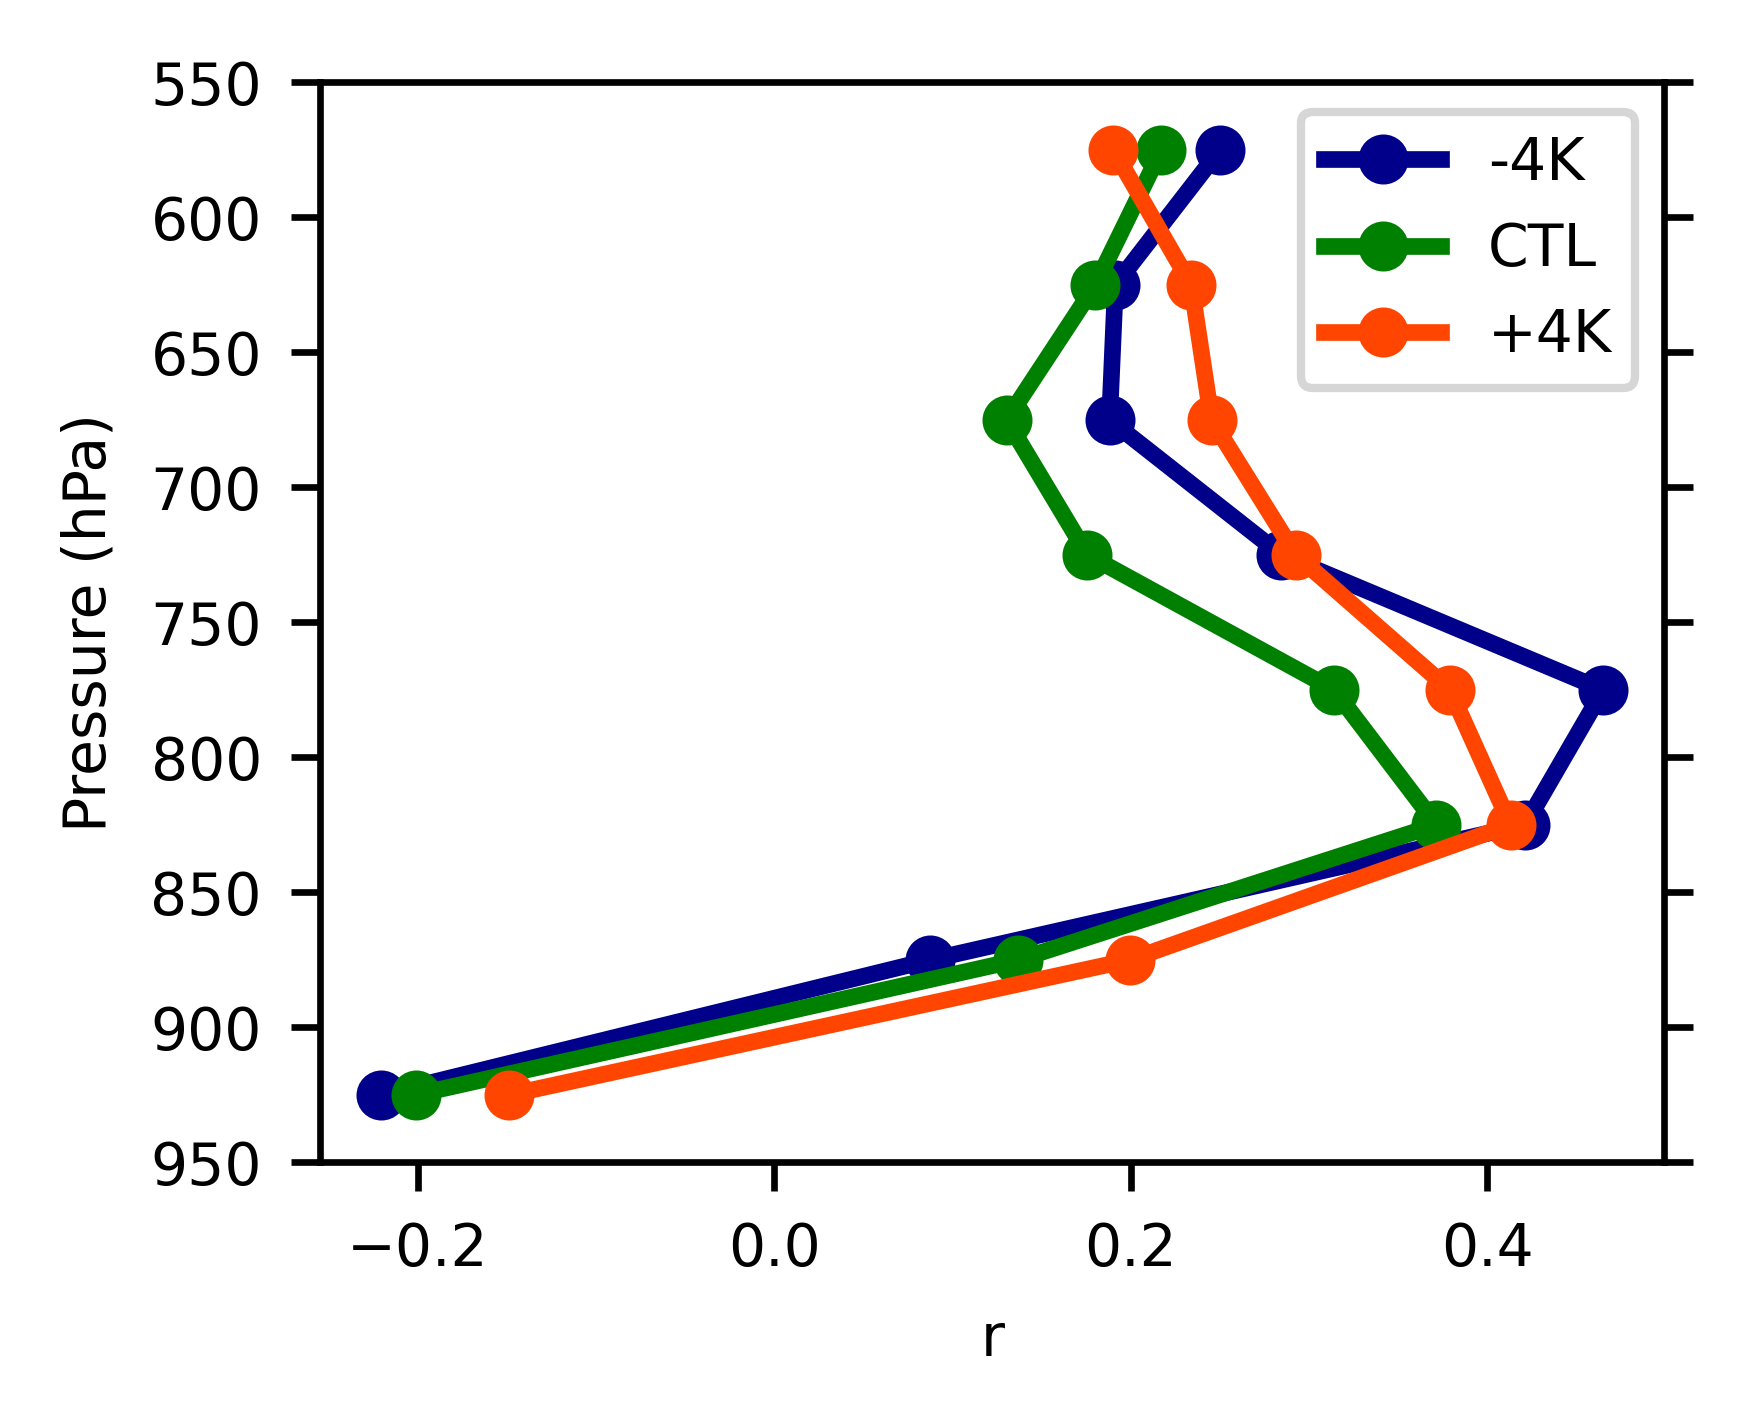

In [11]:
# Load correlation coefficient
for n1 in range(0, 1):#np.size(V1_plev_name)): # q or T
    for n2 in range(1,2):#0, np.size(V2_name)): # precp or PCQ1
        for icase in range(0, 3):
            CASENAME       = CASENAME_LIST2[icase]+'_'+NUDGE_LIST[icase]
            output_dir     = dir_out+'output_data/'+CASENAME+'/'
            data = np.load(output_dir+'corrcoef_'+V1_short[n1]+'_'+V2_short[n2]+'_level.npz')
            if icase == 0:
                plev_new = data['plev']
                #print(plev_new)
                nlev_new = np.size(plev_new)
                r = np.empty([nlev_new, 3])
                r_below_500 = np.empty([nlev_new, 3])
                r_below_500_above_950 = np.empty([nlev_new, 3])
            r[:,icase] = data['r']
            r_below_500[:,icase] = np.where(plev_new<550, np.nan, r[:,icase])
            r_below_500_above_950[:,icase] = np.where(plev_new>950, np.nan, r_below_500[:,icase])
        
        # Plot correlation coefficient  
        font = 7
        fig,axes = plt.subplots(1,1,figsize=(3.2, 2.4),dpi=600)
        plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.15,wspace=0.1)
        plt.rcParams.update({'font.size': font})
        if n1 == 0:
            #plt.plot(r_below_500[:,0], plev_new, color='darkblue',marker='o',markersize=5, linewidth=2)
            #plt.plot(r_below_500[:,1], plev_new, color='green',marker='o',markersize=5, linewidth=2)
            #plt.plot(r_below_500[:,2], plev_new, color='orangered',marker='o',markersize=5, linewidth=2)
            plt.plot(r_below_500_above_950[:,0], plev_new, color='darkblue',marker='o',markersize=5, linewidth=2)
            plt.plot(r_below_500_above_950[:,1], plev_new, color='green',marker='o',markersize=5, linewidth=2)
            plt.plot(r_below_500_above_950[:,2], plev_new, color='orangered',marker='o',markersize=5, linewidth=2)
            plt.ylim([550, 950])#np.max(plev_new)])
            plt.yticks( np.arange(550, 1000, 50) )
        else:
            zero = np.zeros([nlev_new])
            plt.plot(r[:,0], plev_new, color='darkblue',marker='o',markersize=5, linewidth=2)
            plt.plot(r[:,1], plev_new, color='green',marker='o',markersize=5, linewidth=2)
            plt.plot(r[:,2], plev_new, color='orangered',marker='o',markersize=5, linewidth=2)      
            plt.plot(zero, plev_new, 'k:')
            plt.ylim([550, 950])#np.max(plev_new)])
            plt.yticks( np.arange(100, 1000, 100) )
        plt.tick_params(bottom=True,top=False,left=True,right=True)
        plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        plt.gca().invert_yaxis()
        plt.xlabel('r')
        #plt.title('Correlation coefficient: '+V1_short[n1]+' & '+V2_short[n2])
        plt.ylabel('Pressure (hPa)')
        plt.legend(['-4K','CTL','+4K'])
        plt.savefig(figdir_all+'Fig.3_corrcoef_'+V1_short[n1]+'_'+V2_short[n2]+'_level.png',dpi=600)
        plt.show()